In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from read_csv_file import read_csv_file
file_path = '/Users/remiliascarlet/Desktop/MDP/transfer_learning/burst_data/csv/240330182002-PeachMountian.csv'


In [20]:
df = read_csv_file(file_path)
# if df is not None:
#     print("DataFrame head:\n", df)

dates = df['Date']
times = df['Time']
frequency = df.columns[2:].astype(int)
data = df.iloc[:, 2:]

# print("Dates:\n", dates.head())
# print("Times:\n", times.head())
# print("Frequency (Hz):\n", frequency)
# print("Data:\n", data.head())

High variance columns: [   4    5    6 ... 8618 8619 8620]
Low variance rows: [  0   1 135 140 148 289 291 305 306 307 308 309 310 311 312 313 314 315
 316 317 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334
 335 336 337 338 339 340 341 342 344 345 346 347 348 349 350 351 352 353
 354 355 356 357 358 359 360 361 362 363 364 365 396 398 399 410]


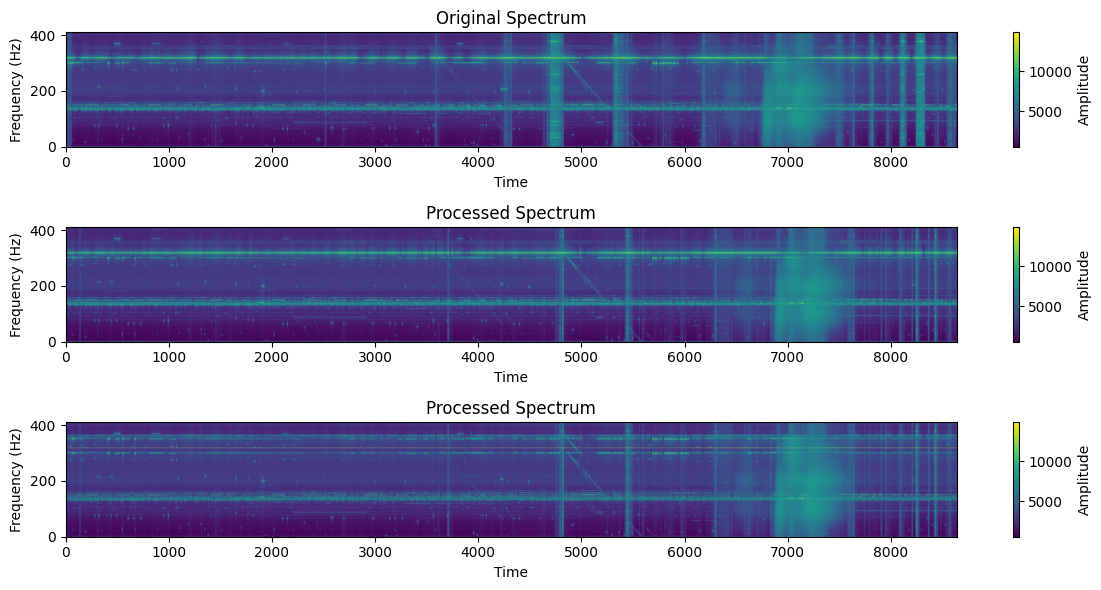

In [21]:
from data_denoise import remove_horizontal_noise, remove_vertical_noise

remove_horizontal_data = remove_horizontal_noise(data)
removed_data = remove_vertical_noise(remove_horizontal_data)
# removed_data = remove_horizontal_data

plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.imshow(data.T, aspect='auto', origin='lower', cmap='viridis')
plt.title('Original Spectrum')
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Amplitude')

plt.subplot(3, 1, 2)
plt.imshow(remove_horizontal_data.T, aspect='auto', origin='lower', cmap='viridis')
plt.title('Processed Spectrum')
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Amplitude')

plt.subplot(3, 1, 3)
plt.imshow(removed_data.T, aspect='auto', origin='lower', cmap='viridis')
plt.title('Processed Spectrum')
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Amplitude')

plt.tight_layout()
plt.show()

start_index: 6751 end_index: 7582


/Users/remiliascarlet/Desktop/MDP/transfer_learning/radburst_tl/data_preprocessing/data_label.py:188: FutureWarning: The 'axis' keyword in DataFrame.rolling is deprecated and will be removed in a future version. Call the method without the axis keyword instead.
  filtered_mask_df = mask_df.rolling(window=window_size, axis=0, center=True).median()


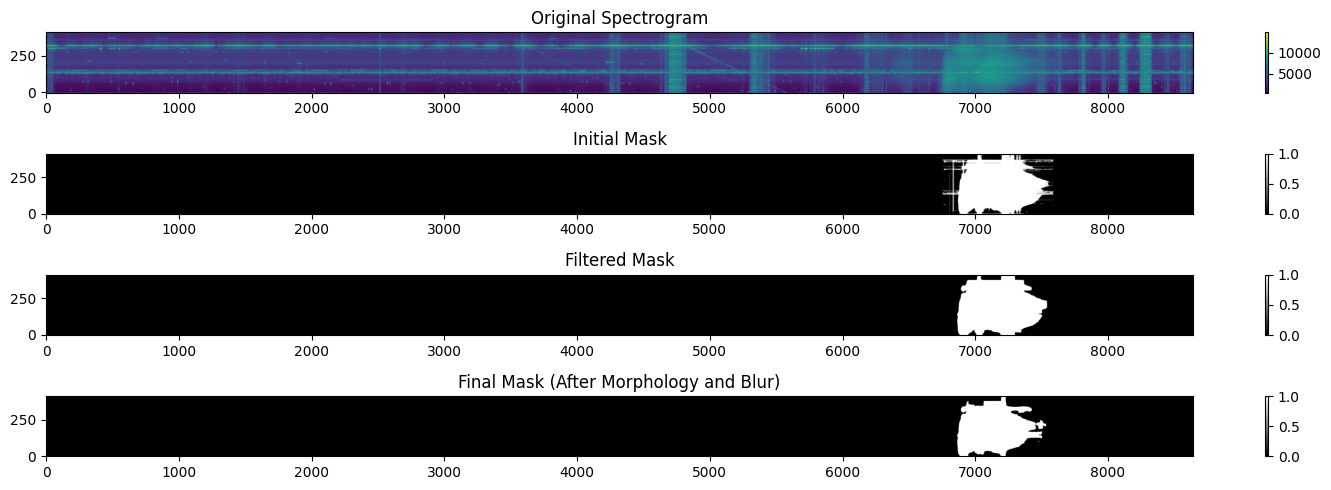

In [22]:
from data_label import time_to_column_indices, create_srb_mask, apply_morphological_operations, blur, apply_rolling_median_filter, intersect_srb_masks

start_time_str = '18:31:17' # Replace with the actual onset time of your data
end_time_str = '18:32:40' # Replace with the actual offset time of your data

start_index, end_index = time_to_column_indices(times, start_time_str, end_time_str)
print("start_index:", start_index, "end_index:", end_index)

initial_mask = create_srb_mask(removed_data, start_index, end_index)
morph_mask = apply_morphological_operations(initial_mask, erosion_radius=5, dilation_radius=10, operation_sequence=['erode', 'dilate'])
filtered_mask = apply_rolling_median_filter(morph_mask, window_size=3)
# final_mask = blur(morph_mask, blur_filter_shape=(5, 5))

undeniosed_mask = create_srb_mask(data, start_index, end_index)
undeniosed_morph_mask = apply_morphological_operations(undeniosed_mask, erosion_radius=2, dilation_radius=10, operation_sequence=['erode', 'dilate'])
undeniosed_filtered_mask = apply_rolling_median_filter(undeniosed_morph_mask, window_size=3)

final_mask = intersect_srb_masks(filtered_mask, undeniosed_filtered_mask)

# Plotting
plt.figure(figsize=(15, 5))

plt.subplot(4, 1, 1)
plt.imshow(data.T, aspect='auto', cmap='viridis', origin='lower')
plt.title('Original Spectrogram')
plt.colorbar()

plt.subplot(4, 1, 2)
plt.imshow(initial_mask.T, aspect='auto', cmap='gray', origin='lower')
plt.title('Initial Mask')
plt.colorbar()

plt.subplot(4, 1, 3)
plt.imshow(filtered_mask.T, aspect='auto', cmap='gray', origin='lower')
plt.title('Filtered Mask')
plt.colorbar()

plt.subplot(4, 1, 4)
plt.imshow(final_mask.T, aspect='auto', cmap='gray', origin='lower')
plt.title('Final Mask (After Morphology and Blur)')
plt.colorbar()

plt.tight_layout()
plt.show()

#Filtered mask is Best!
using_data = remove_horizontal_data
using_mask = filtered_mask


Generated 12 spectrogram slices
Slice shape: (256, 256)
Mask slice shape: (256, 256)
Slice position: [(0, 6495), (155, 6495), (0, 6687), (155, 6687), (0, 6879), (155, 6879), (0, 7071), (155, 7071), (0, 7263), (155, 7263), (0, 7455), (155, 7455)]


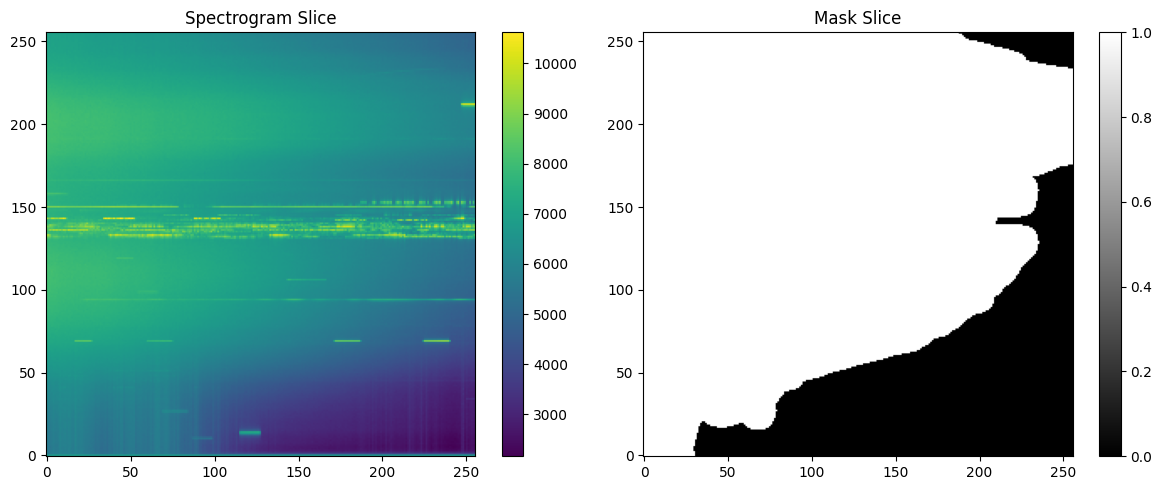

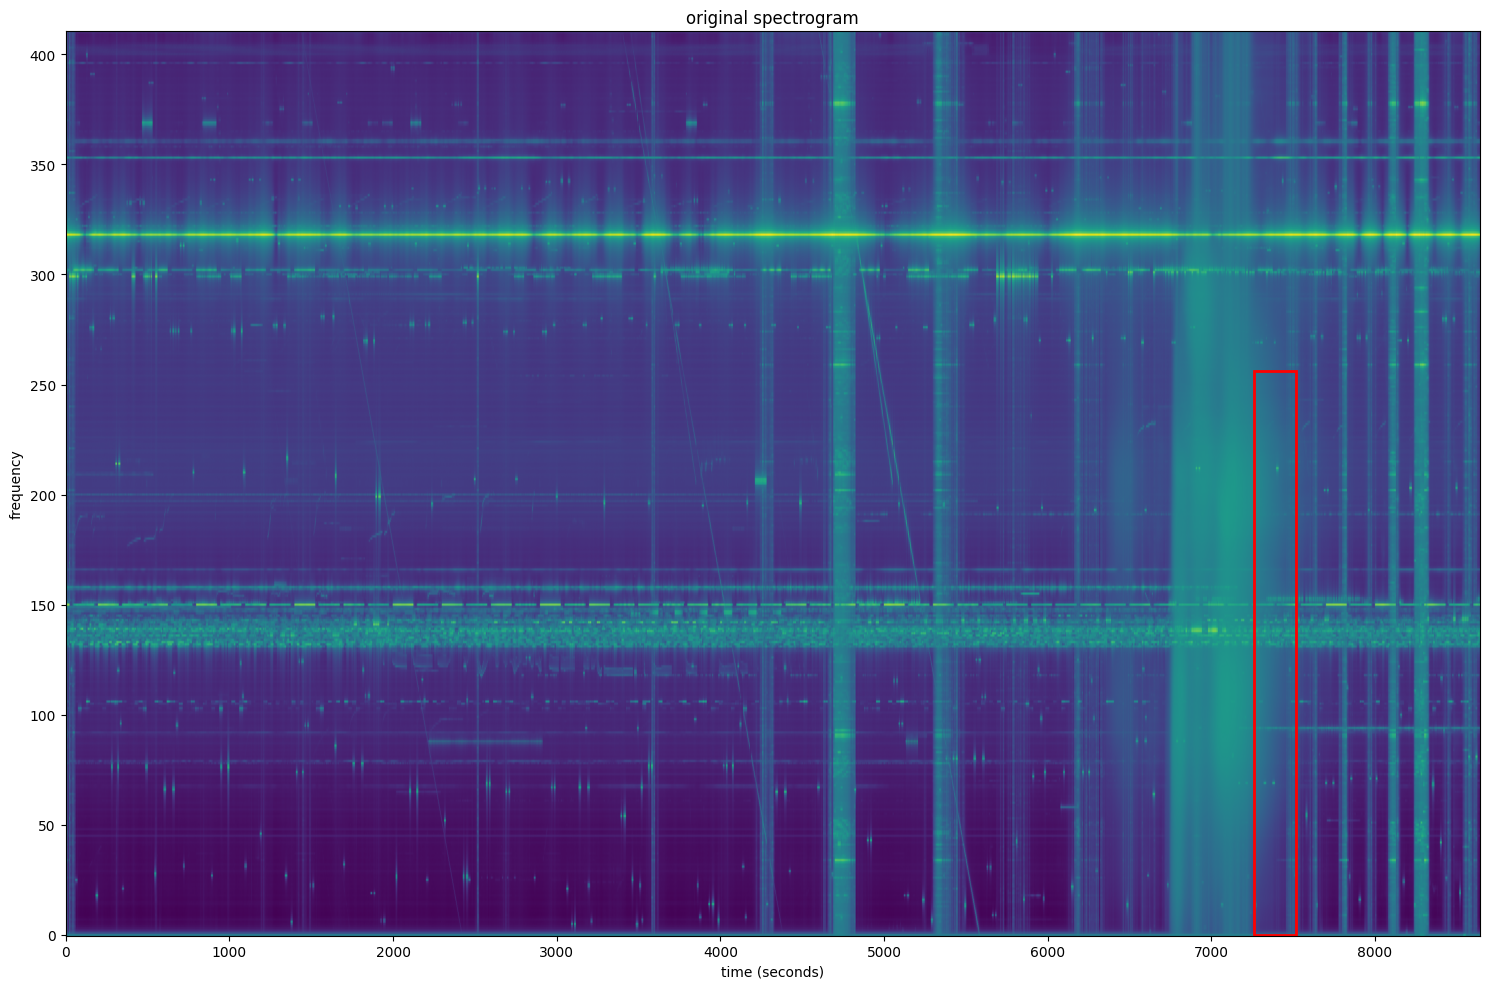

Saved 12 spectrogram slices to /Users/remiliascarlet/Desktop/MDP/transfer_learning/burst_data/csv/saved_slices


In [23]:
# Data Slicing

from data_slicing import SpectrogramSlicer

# Initialize the slicer
slicer = SpectrogramSlicer(target_size=(256, 256), overlap_ratio=0.25, random_offset=False)

# Slice the spectrogram and mask
# Note: 'times' is the array of timestamps, 'using_data' is the spectrogram data, and 'using_mask' is the mask data
slices, mask_slices, positions = slicer.slice_spectrogram_time_range(
    spectrogram=using_data.T,
    time_array=times,
    start_time_str=start_time_str,
    end_time_str=end_time_str,
    mask=using_mask.T,
    time_padding=0.2,
    is_training=False  # Set to False for deterministic slicing
)

# Output slice information
print(f"Generated {len(slices)} spectrogram slices")
print(f"Slice shape: {slices[0].shape}")
print(f"Mask slice shape: {mask_slices[0].shape}")
print(f"Slice position: {positions}")

# Optional: Visualize the first slice and its mask
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(slices[8], aspect='auto', cmap='viridis', origin='lower')
plt.title('Spectrogram Slice')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(mask_slices[8], aspect='auto', cmap='gray', origin='lower')
plt.title('Mask Slice')
plt.colorbar()

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 10))

# 使用转换后的时间作为 x 轴范围
plt.imshow(data.T, aspect='auto', cmap='viridis', origin='lower')
plt.title('original spectrogram')
plt.xlabel('time (seconds)')
plt.ylabel('frequency')

# 仅框出 positions 中第一个切片
if len(positions) > 0:
    y, x = positions[8]  # positions 返回 (y, x)
    # 根据 x（时间轴索引）从 times 数组中获取起始时间
    
    x_start = times[x]
    if x + slicer.target_width < len(times):
        x_end = times[x + slicer.target_width]
    else:
        x_end = times[-1]
    
    # y 方向直接使用像素值
    y_start = y
    y_end = y + slicer.target_height

    # 绘制红色矩形框（使用秒数作为 x 坐标）
    rect = plt.Rectangle((x, y_start), 256, 256, 
                         linewidth=2, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)

plt.tight_layout()
plt.show()



# Optional: Save slices to CSV files
metadata = {
    'date': '20240330', # change to the actual date!!!
    'start_time': start_time_str.replace(':', '')
}
save_dir = '/Users/remiliascarlet/Desktop/MDP/transfer_learning/burst_data/csv/saved_slices'
saved_files = slicer.save_slices_to_csv(
    slices=slices,
    mask_slices=mask_slices,
    save_dir=save_dir,
    naming_format='slice_{meta_date}_y{y}_x{x}',  # 新的命名格式
    positions=positions,
    metadata=metadata
)

In [24]:
# from data_denoise import remove_vertical_noise
from data_label import detect_srb

# cleaned_mask = detect_srb(removed_data)

# plt.subplot(3, 1, 3)
# plt.plot(cleaned_mask, label='Processed Mask', color='orange')
# plt.title('Processed Mask')
# plt.xlabel('Time')
# plt.ylabel('Mask')
# plt.legend()

